In [1]:
# UT-TOR-DATA-PT-01-2020-U-C Week 11
# Web Design Challenge
# Generation of party results charts. Mandatory part: bar charts with history of seats distribution by election
# (c) Boris Smirnov

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import utilities as u

In [3]:
years_lst = [2004, 2006, 2008, 2011, 2015, 2019]
party_lst = ['LIB', 'CPC', 'NDP', 'BQ', 'GRN']

# I have custom names only for the parties in the list. Very convenient
p_df = u.parties_df[['Id', 'Custom Name']].dropna()
party_names = dict(zip(p_df['Id'], p_df['Custom Name']))

party_colors = {
    'LIB': '#EA6D6A', # red
    'CPC': "#6495ED", # blue
    'NDP': "#F4A460", # orange
    'BQ' : "#87CEFA", # light blue
    'GRN': "#99C955"  # green
}

# Elections that we can compare riding-by-riding
# First group, 2004-2011, corresponds to 2003 representation order (308 ridings)
# Second group, 2015-2019, coresponds to 2013 representation order (338 ridings)
# We cannot compare ridings between 2011 and 2015 elections, because the are from differens ROs
compare_dict = {
    2006: 2004,
    2008: 2006,
    2011: 2008,
    2019: 2015
}

In [4]:
# DataFrame with accumulated elections results for all years
accumulated_df = pd.DataFrame()

for year in years_lst:
    src_file = f"data{year}.csv"
    input_df = pd.read_csv(src_file)

    # For all years but 2008 this would be enough to get the list of winning candidates:
    # winners_df = input_df[input_df['Candidate Pid'] == input_df['Winning Pid']]
    # However, in 2008, FEDs 12007 (NS) and 24051 (QC) each had a pair of independent candidates ('Candidate Pid' == IND),
    # one of whom won ('Winning Pid' == IND), thus the query above will also include 2 independent candidates that lost.
    # This situation is impossible with candidates from parties, but not with independent candidates, thus:
    winners_df = input_df[input_df['Candidate Pid'] == input_df['Winning Pid']].groupby('FED Id').first()

    seats_grp = winners_df.groupby('Candidate Pid')
    seats_df = seats_grp[['Candidate Pid']].count()
    seats_df.columns = [f"{year}"]
    
    if not len(accumulated_df):
        accumulated_df[f"{year}"] = seats_df[f"{year}"]
    else:
        accumulated_df = accumulated_df.merge(seats_df, how="outer", left_index=True, right_index=True)

accumulated_df.fillna(value=0, inplace=True)

In [5]:
accumulated_df

,2004,2006,2008,2011,2015,2019
Candidate Pid,,,,,,
BQ,54.0,51.0,49.0,4.0,10.0,32.0
CPC,99.0,124.0,143.0,166.0,99.0,121.0
GRN,0.0,0.0,0.0,1.0,1.0,3.0
IND,0.0,1.0,2.0,0.0,0.0,1.0
LIB,135.0,103.0,77.0,34.0,184.0,157.0
NDP,19.0,29.0,37.0,103.0,44.0,24.0
NOA,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Generate a chart for a given party
def plot_party_bars(party):

    color = party_colors[party]

    total_seats_lst = [accumulated_df[f"{year}"].sum() for year in years_lst]
    party_seats_lst = accumulated_df.loc[party].to_list()
    max_seats = accumulated_df.loc[party].max()

    fig = plt.figure(figsize=(7.5, 5))
    axes = plt.subplot()
    bars = plt.bar(range(len(years_lst)), party_seats_lst, width=1, align='center', color=color, edgecolor='black', linewidth=1)

    axes.set_title(f"Number of seats occupied by year", fontdict={'fontsize': 14})

    # Labels on top of bars
    # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes.annotate('{:.2f}%'.format(party_seats_lst[i] * 100.0 / total_seats_lst[i]),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Making a legend
    # https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
    legend_handles = [mpatches.Patch(color=party_colors[party], label=party_names[party])]
    plt.legend(handles=legend_handles)

    # X-axis
    axes.set_xlabel('Elections years', fontdict={'fontsize': 12})
    axes.set_xticks([i for i in range(len(years_lst))])
    axes.set_xticklabels([str(year) for year in years_lst])
    axes.set_xlim(left=-0.5, right=len(years_lst) - 0.5)

    # Y-axis
    axes.set_ylabel('Number of seats', fontdict={'fontsize': 12})
    axes.set_yticks(party_seats_lst)
    axes.set_ylim(top=max_seats * 1.07)
    axes.yaxis.grid()

    plt.savefig(f"../images/history_{party}_bars.svg", bbox_inches = 'tight')
    plt.show()

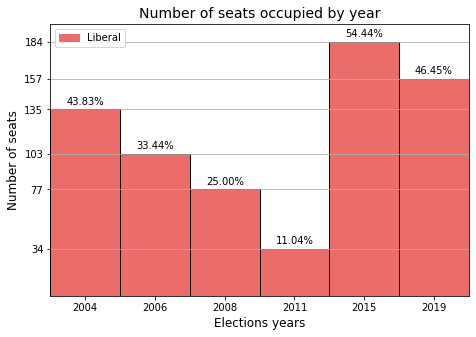

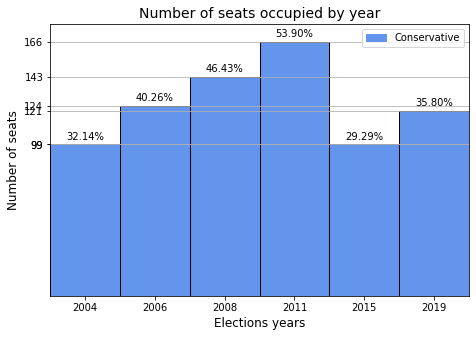

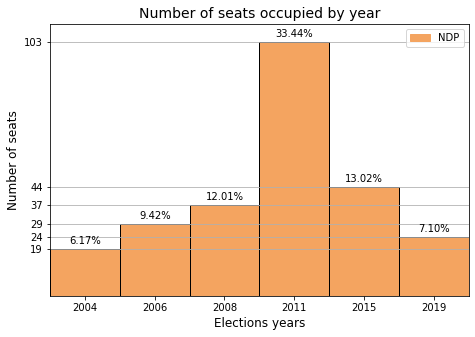

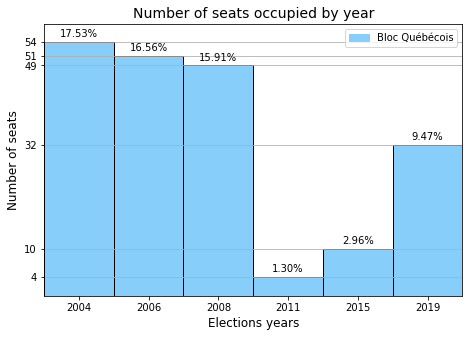

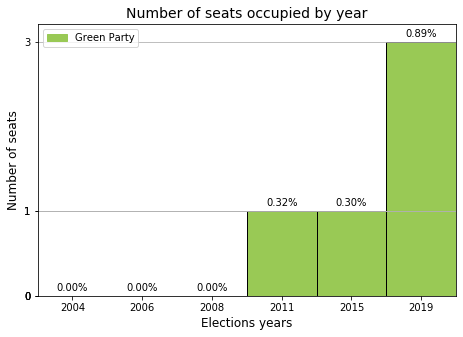

In [7]:
# Generate a barchart with elections results for every year
for party in party_lst:
    plot_party_bars(party)